In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
conn = sqlite3.connect('data/database.db')
cursor = conn.cursor()

## Read the data

In [3]:
questions = pd.read_sql_query("SELECT * FROM question", conn)
answers = pd.read_sql_query("SELECT * FROM answer", conn)
tags = pd.read_sql_query("SELECT * FROM tag", conn)

In [4]:
questions.info()
questions.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 2999 non-null   int64 
 1   title              2999 non-null   object
 2   body_with_tags     2999 non-null   object
 3   body_without_tags  2999 non-null   object
 4   votes              2999 non-null   int64 
 5   url                2999 non-null   object
 6   views              2999 non-null   int64 
 7   created_date       2999 non-null   object
 8   modified_date      2999 non-null   object
dtypes: int64(3), object(6)
memory usage: 211.0+ KB


,id,title,body_with_tags,body_without_tags,votes,url,views,created_date,modified_date
0,1,Why is processing a sorted array faster than p...,"<div class=""s-prose js-post-body"" itemprop=""te...","\nIn this C++ code, sorting the data (before t...",27153,https://stackoverflow.com/q/11227809,1848348,2012-06-27 13:51:36,2023-09-19 09:35:58
1,2,How do I undo the most recent local commits in...,"<div class=""s-prose js-post-body"" itemprop=""te...",\nI accidentally committed the wrong files to ...,26030,https://stackoverflow.com/q/927358,13393115,2009-05-29 18:09:14,2023-11-16 03:37:28


In [5]:
answers.info()
answers.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60319 entries, 0 to 60318
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 60319 non-null  int64 
 1   body_with_tags     60319 non-null  object
 2   body_without_tags  60319 non-null  object
 3   votes              60319 non-null  int64 
 4   url                60319 non-null  object
 5   accepted           60319 non-null  int64 
 6   created_date       60319 non-null  object
 7   question_id        60319 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 3.7+ MB


,id,body_with_tags,body_without_tags,votes,url,accepted,created_date,question_id
0,1,"<div class=""s-prose js-post-body"" itemprop=""te...",\nYou are a victim of branch prediction fail.\...,34849,https://stackoverflow.com/a/11227902,1,2012-06-27 13:56:42,1
1,2,"<div class=""s-prose js-post-body"" itemprop=""te...","\nBranch prediction.\nWith a sorted array, the...",4659,https://stackoverflow.com/a/11227877,0,2012-06-27 13:54:45,1


In [6]:
tags.info()
tags.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2126 non-null   int64 
 1   name    2126 non-null   object
 2   url     2126 non-null   object
dtypes: int64(1), object(2)
memory usage: 50.0+ KB


,id,name,url
0,1,java,https://stackoverflow.com/questions/tagged/java
1,2,c++,https://stackoverflow.com/questions/tagged/c%2...


## Analysis with Visualization

In [7]:
print("Summary Statistics for Question Votes:")
print(questions['votes'].describe())
print()
print("Summary Statistics for Answer Votes:")
print(answers['votes'].describe())

Summary Statistics for Question Votes:
count     2999.000000
mean      1540.661554
std       1397.536071
min        732.000000
25%        865.000000
50%       1103.000000
75%       1671.000000
max      27153.000000
Name: votes, dtype: float64

Summary Statistics for Answer Votes:
count    60319.000000
mean       152.651188
std        601.076276
min        -65.000000
25%          4.000000
50%         12.000000
75%         48.000000
max      34849.000000
Name: votes, dtype: float64


In [8]:
acceptance_rate = answers['accepted'].mean() * 100
print(f"{acceptance_rate:.2f}% of answers are accepted.")

4.50% of answers are accepted.


In [9]:
# Percentage of questions with an accepted answer
accepted_answers = answers[answers['accepted'] == 1]
accepted_answers = accepted_answers['question_id'].unique()
accepted_answers = len(accepted_answers)
total_questions = len(questions['id'].unique())
percentage = accepted_answers / total_questions * 100
print(f"{percentage:.2f}% of questions have an accepted answer.")

90.60% of questions have an accepted answer.


In [10]:
# Add a column to represent whether an answer is the top-voted and accepted
answers['is_top_voted_and_accepted'] = (answers.groupby('question_id')['votes'].transform('max') == answers['votes']) & (answers['accepted'] == 1)

# Print the results
print("Number of top-voted and accepted answers:", answers['is_top_voted_and_accepted'].sum())
print("Number of accepted answers:", answers['accepted'].sum())
print(f"Percentage of accepted answers that are top-voted: {(answers['is_top_voted_and_accepted'].sum() / answers['accepted'].sum() * 100):.2f}%")

Number of top-voted and accepted answers: 2410
Number of accepted answers: 2717
Percentage of accepted answers that are top-voted: 88.70%


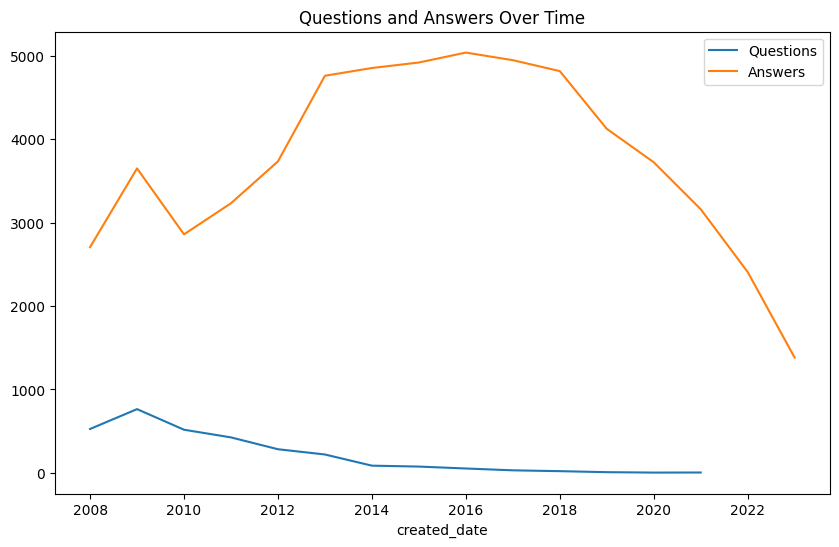

In [11]:
plt.figure(figsize=(10, 6))
questions['created_date'] = pd.to_datetime(questions['created_date'])
answers['created_date'] = pd.to_datetime(answers['created_date'])
questions.groupby(questions['created_date'].dt.year).size().plot(label='Questions')
answers.groupby(answers['created_date'].dt.year).size().plot(label='Answers')
plt.title('Questions and Answers Over Time')
plt.legend()

In [12]:
tags_with_year_and_count = pd.read_sql("""
    SELECT Tag.name, strftime('%Y', Question.created_date) as year, COUNT(*) AS count
    FROM Question
    JOIN Question_Tag ON Question.id = Question_Tag.question_id
    JOIN Tag ON Question_Tag.tag_id = Tag.id
    GROUP BY Tag.name, year
    ORDER BY count DESC
""", conn)
tags_with_year_and_count.head()

,name,year,count
0,javascript,2009,145
1,python,2009,118
2,git,2009,95
3,git,2010,83
4,javascript,2008,80


Text(0.5, 1.0, 'Top 10 Tags')

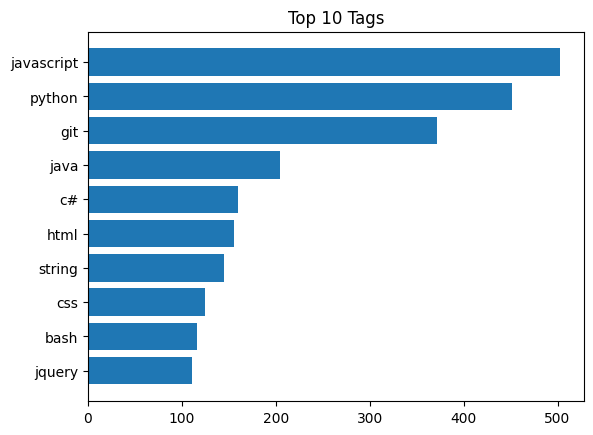

In [13]:
top_10_tags = tags_with_year_and_count.groupby('name').sum().sort_values('count', ascending=False).head(10)
top_10_tags.sort_values('count', ascending=True, inplace=True)
plt.barh(range(len(top_10_tags)), top_10_tags['count'])
plt.yticks(range(len(top_10_tags)), top_10_tags.index)
plt.title("Top 10 Tags")


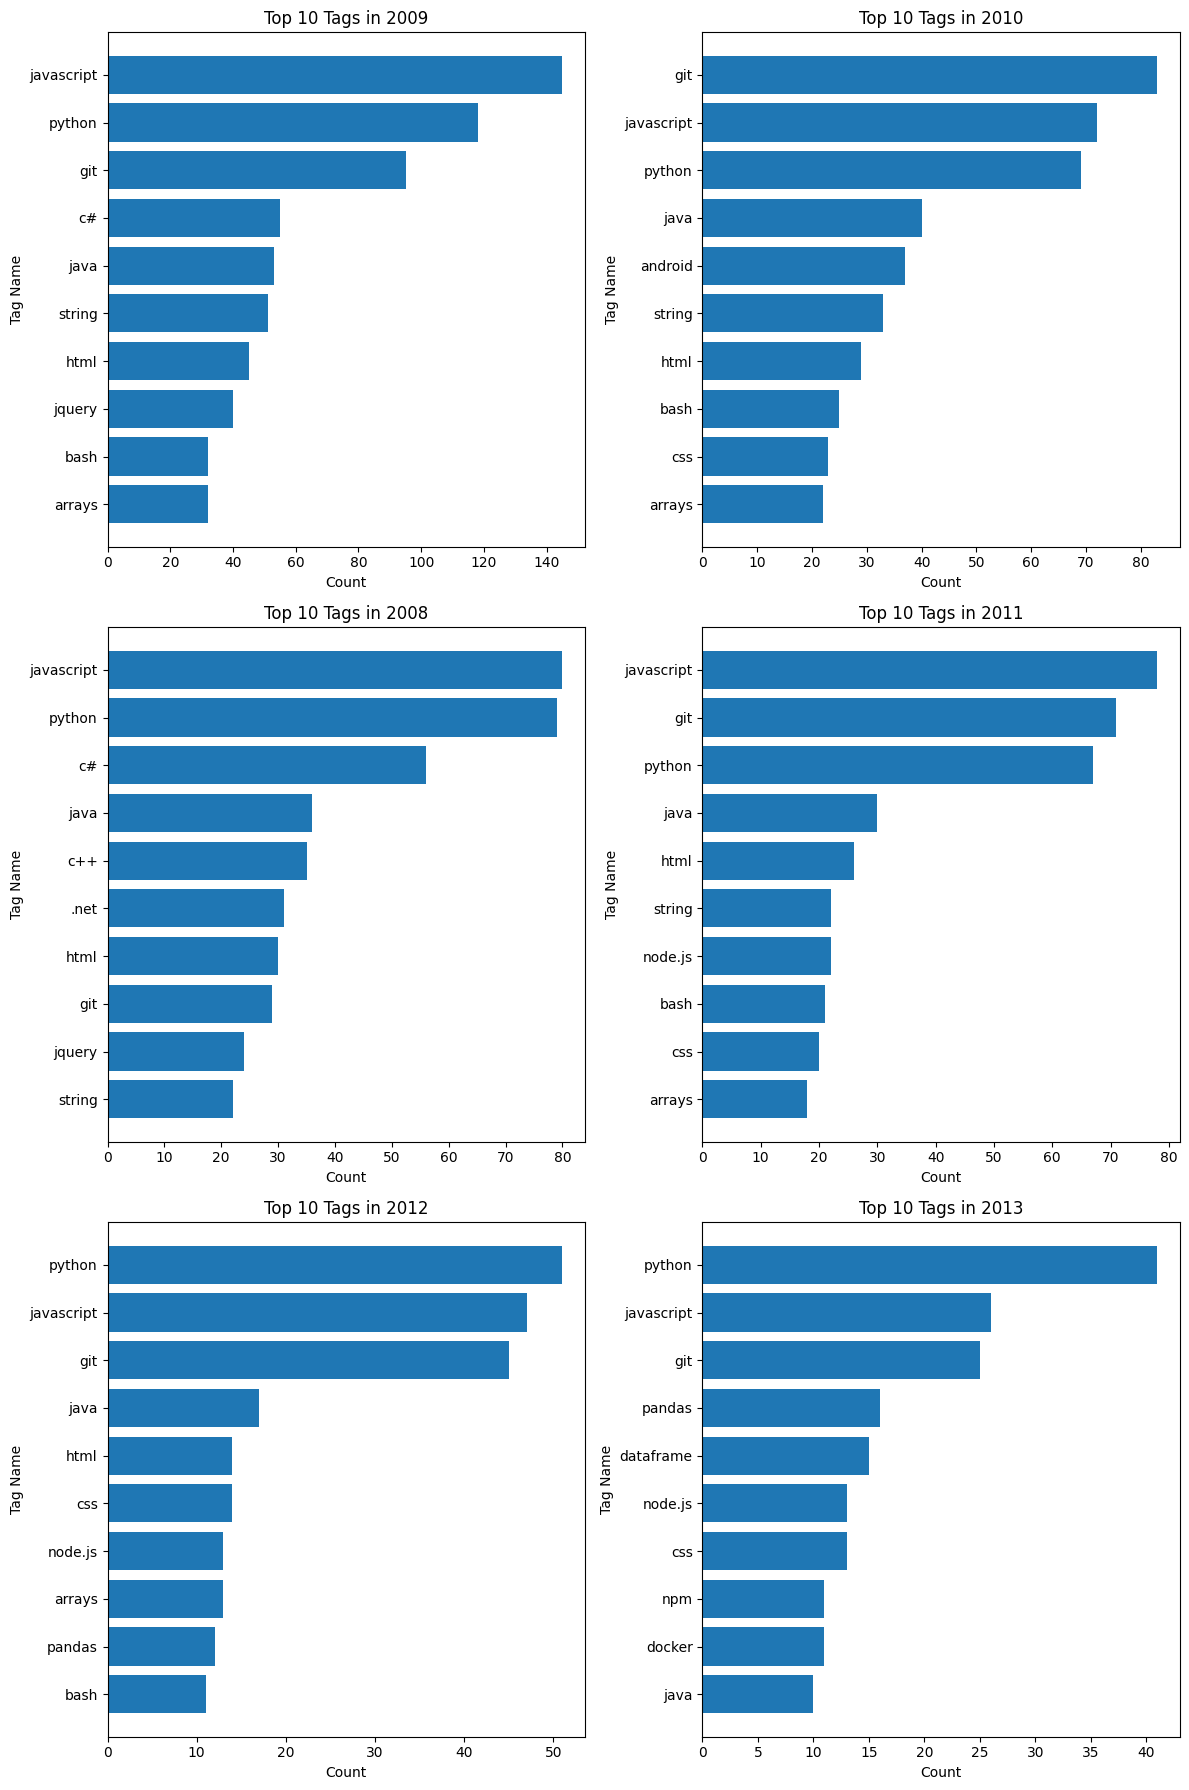

In [14]:
# Get unique years in the dataset
unique_years = tags_with_year_and_count['year'].unique()

unique_years = unique_years[unique_years <= '2013']

# Define the number of tags to display for each year
top_tags_count = 10

# Set up subplots for multiple pages
fig, axs = plt.subplots(nrows=len(unique_years)//2, ncols=2, figsize=(12, 18))

# Flatten the 2D array of subplots for easier iteration
axs = axs.flatten()

# Iterate through each year and create a bar graph
for i, year in enumerate(unique_years):
    # Extract data for the current year and select the top tags
    data_for_year = tags_with_year_and_count[tags_with_year_and_count['year'] == year]
    top_tags = data_for_year.nlargest(top_tags_count, 'count')
    top_tags.sort_values(by='count', ascending=True, inplace=True)

    # Plot a horizontal bar chart
    axs[i].barh(top_tags['name'], top_tags['count'])
    
    # Set labels and title
    axs[i].set_xlabel('Count')
    axs[i].set_ylabel('Tag Name')
    axs[i].set_title(f'Top {top_tags_count} Tags in {year}')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [15]:
corr_questions = questions[['votes', 'views']].corr()
print("Correlation between Votes and Views for Questions:", corr_questions['votes']['views'])

corr_answers = answers[['votes', 'accepted']].corr()
print("Correlation between Votes and Accepted for Answers:", corr_answers['votes']['accepted'])


Correlation between Votes and Views for Questions: 0.5613922273198165
Correlation between Votes and Accepted for Answers: 0.6226265038593511
